# Case Study 2

Studying the Laplace PDE:

$${\partial^2 T \over \partial x^2} + {\partial^2 T \over \partial y^2} = 0$$


Considering a flat two dimensional rectangular plate in the (x, y)-coordinate plane. The goal is to calculate the steady state temperature distribution for the following boundary conditions:

- $T(x, y=0) = T_1$
- $T(x=0, y>0) = T_2$
- $T(x, y=H) = T_3$
- $T(x=L, y>0) = T_4$

The plate has dimensions 1 meter along x and 2 meters along y, such that
- $L = 1$
- $H = 2$

with 51 points in x and 101 points in y, such that 
- $jm = 50$ (for x, with point indices $j = 0, 1, ..., jm$)
- $im = 100$ (for y, with point indices $i = 0, 1, ..., im$)

The temperatures are given by:
- $T_1 = 100$ degrees celcius
- $T_2 = T_3 = T_4 = 0$

In [92]:
# imports
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Variables

In [146]:
H = 2
L = 1
T0 = 0
im = 50 # steps in x
jm = 100 # steps in y
x = np.linspace(0, L, im+1) # x-grid
y = np.linspace(0, H, jm+1) # y-grid
dx = L/im
dy = H/jm

# convergence tolerance
epsilon = 2e-10


# initialise the initial temperature distribution array with rows = y, and columns = x
initial_T = np.zeros((jm+1, im+1))
# add T(x, y=0) = 100 boundary condition
initial_T[-1, :] = np.ones(im+1) * 100 
initial_T

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [100., 100., 100., ..., 100., 100., 100.]])

# 1. Methods Code

## Jacobi

In [147]:
def Jacobi(init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # initialise the updated matrix to be equal to the initial distribution -> internal values will then be updated
    updated_T = init_T.copy()
    
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    # iteratively update the initial matrix, going from top to bottom (along each column), from left to right.
    # Note that only the interior points are updated
    while diffs > tol:
        # add an iteration
        it += 1
        
        # update the matrix
        for j in range(1, jm): # row = y, col = x
            for i in range(1, im):
                updated_T[j, i] = (init_T[j,i+1] + init_T[j,i-1] + B**2 * init_T[j+1,i] + B**2 * init_T[j-1,i]) / (2*(1+B**2))
        
        # calculate convergence metric
        diffs = np.sum(np.abs(np.subtract(updated_T, init_T)))
        
        # store residual value
        residuals.append(diffs)
        
        # replace old with new matrix
        init_T = updated_T.copy()
    
    return it, updated_T, residuals
        

## Gauss-Seidel

In [148]:
def Gauss_Seidel(init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    # Successively update the initial matrix for each point, making use of previously updated values.
    # Only interior points are updated. Solves top to bottom going from left to right.
    while diffs > tol:
        # add an iteration
        it += 1
        
        # save previous matrix
        curr_T = init_T.copy()
        
        # update the matrix: ascending in i and j 
        for j in range(jm-1, 0, -1): # row = y, col = x
            for i in range(1, im):
                init_T[j, i] = (init_T[j,i+1] + init_T[j,i-1] + B**2 * init_T[j+1,i] + B**2 * init_T[j-1,i]) / (2*(1+B**2))
        
        # calculate convergence metric
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals
        

## Line Gauss-Seidel

In [149]:
def LGS_row(init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # tridiagonal vectors (exclude boundaries: iterate over j = 1, ..., jm-1. For each one getting i = 1, ..., im-1 values)
    a = np.ones(im - 2)
    b = np.ones(im - 1) * -2*(1 + B**2)
    c = np.ones(im - 2)
    
    # construct A matrix in Au = d
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    
    # initialise constant vector
    d = np.zeros(im - 1)
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    while diffs > tol:
        # add an iteration
        it += 1
        
        # current iteration matrix
        curr_T = init_T.copy()
        
        # update each row one by one, at once
        for j in range(jm-1, 0, -1):
            # i = 1: i=0 boundary involved (T=0)
            d[0] = -B**2 *(init_T[j-1, 1] + init_T[j+1, 1]) - 0
            
            # i = 2, ..., im-2: no boundaries involved
            d[1:-1] = -B**2 *(init_T[j-1, 2:im-1] + init_T[j+1, 2:im-1])
    
            # i = im-1: i=im boundary involved (T=0)
            d[-1] = -B**2 *(init_T[j-1, im-1] + init_T[j+1, im-1]) - 0
            
            # update jth inner row
            init_T[j, 1:-1] = np.linalg.solve(A, d)
            
        # calculate difference
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals




def LGS_col(init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # tridiagonal vectors (exclude boundaries: iterate over j = 1, ..., jm-1. For each one getting i = 1, ..., im-1 values)
    a = np.ones(jm - 2) * B**2
    b = np.ones(jm - 1) * -2*(1 + B**2)
    c = np.ones(jm - 2) * B**2
    
    # construct A matrix in Au = d
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    
    
    # initialise constant vector
    d = np.zeros(jm - 1)
    
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    while diffs > tol:
        # add an iteration
        it += 1
        
        # current iteration matrix
        curr_T = init_T.copy()
        
        # update each row one by one, at once
        for i in range(1, im):
            # j = 1: j=0 boundary involved (T=0)
            d[0] = - init_T[1, i-1] - init_T[1, i+1] - 0
            
            # j = 2, ..., jm-2: no boundaries involved
            d[1:-1] = - init_T[2:jm-1, i-1] - init_T[2:jm-1, i+1]
    
            # j = jm-1: j=jm boundary involved (T=0)
            d[-1] = - init_T[jm-1, i-1] - init_T[jm-1, i+1] - B**2 * 100
            
            # update jth inner row
            init_T[1:-1, i] = np.linalg.solve(A, d)
            
        # calculate difference
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals


## Successive Over-relaxation

In [315]:
def SOR(w, init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    # Successively update the initial matrix for each point, making use of previously updated values.
    # Only interior points are updated. Solves top to bottom going from left to right.
    while diffs > tol:
        # add an iteration
        it += 1

        # save previous matrix
        curr_T = init_T.copy()
        
        # update the matrix
        for j in range(jm-1, 0, -1): # row = y, col = x
            for i in range(1, im):
                GS = (init_T[j,i+1] + init_T[j,i-1] + B**2 * (init_T[j+1,i] + init_T[j-1,i])) / (2*(1+B**2))
                correction = w * (GS - init_T[j,i])
                init_T[j,i] += correction
                # init_T[j, i] = init_T[j, i] - w*init_T[j, i] + w * ((init_T[j,i+1] + init_T[j,i-1] + B**2 * init_T[j+1,i] + B**2 * init_T[j-1,i]) / (2*(1+B**2)))
        
        # calculate convergence metric
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        if it > 50000:
            print('Slow convergence')
            return 50000, init_T, residuals
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals

## Line Successive Over-relaxation

### Line = row

In [355]:
def LSOR_row(w, init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # tridiagonal vectors (exclude boundaries: iterate over j = 1, ..., jm-1. For each one getting i = 1, ..., im-1 values)
    a = np.ones(im - 2) * w
    b = np.ones(im - 1) * - 2*(1 + B**2)
    c = np.ones(im - 2) * w
    
    # Put together matrix A in Au = d
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    
    # initialise constant vector
    d = np.zeros(im - 1)
    
    # constants for known part (d)
    c1 = - (1 - w) * (2 * (1 + B**2))
    c2 = - w * B**2
    
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    while diffs > tol:
        # add an iteration
        it += 1
        
        # current iteration matrix
        curr_T = init_T.copy()
        
        # update each row one by one, at once
        for j in range(jm-1, 0, -1):
            # i = 1: i=0 boundary involved (T=0)
            d[0] = c1*init_T[j,1] + c2*(init_T[j-1, 1] + init_T[j+1, 1]) - 0
            
            # i = 2, ..., im-2: no boundaries involved
            d[1:-1] = c1*init_T[j, 2:im-1] + c2*(init_T[j-1, 2:im-1] + init_T[j+1, 2:im-1])
    
            # i = im-1: i=im boundary involved (T=0)
            d[-1] = c1*init_T[j,im-1] + c2*(init_T[j-1, im-1] + init_T[j+1, im-1]) - 0
            
            # update jth inner row
            init_T[j, 1:-1] = np.linalg.solve(A, d)
            
        # calculate difference
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        if it > 50000:
            print('Slow convergence')
            return 50000, init_T, residuals
        
        if diffs > 1e50:
            print(f'with omega ={w}, it fails to converge')
            return float('nan'), residuals
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals

### Line = column

In [557]:
def LSOR_col(w, init_T=initial_T.copy(), tol = epsilon, im=50, jm=100):
    # step sizes
    dx = L/im
    dy = H/jm
    
    # B coefficient in Jacobi scheme
    B = dx/dy
    
    # tridiagonal vectors (exclude boundaries: iterate over j = 1, ..., jm-1. For each one getting i = 1, ..., im-1 values)
    a = np.ones(jm - 2) * w*B**2
    b = np.ones(jm - 1) * -2*(1 + B**2)
    c = np.ones(jm - 2) * w*B**2
    
    # constructing matrix A in Au = d
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    
    # initialise constant vector
    d = np.zeros(jm - 1)
    
    
    # coefficients for known part
    c1 = -(1 - w)*(2*(1+B**2))
    c2 = - w
    
    
    # count iterations and initialise convergence metric
    it = 0
    diffs = float('inf')
    residuals = []
    
    while diffs > tol:
        # add an iteration
        it += 1
        
        # current iteration matrix
        curr_T = init_T.copy()
        
        # update each row one by one, at once
        for i in range(1, im):
            # j = 1: j=0 boundary involved (T=0)
            d[0] = c1*init_T[1,i] + c2*(init_T[1, i-1] + init_T[1, i+1]) - 0
            
            # j = 2, ..., jm-2: no boundaries involved
            d[1:-1] = c1*init_T[2:jm-1,i] + c2*(init_T[2:jm-1, i-1] + init_T[2:jm-1, i+1])
    
            # j = jm-1: j=jm boundary involved (T=100)
            d[-1] = c1*init_T[jm-1,i] + c2*(init_T[jm-1, i-1] + init_T[jm-1, i+1]) - w*B**2 * 100
            
            # update jth inner row
            init_T[1:-1, i] = np.linalg.solve(A, d)
            
        # calculate difference
        diffs = np.sum(np.abs(np.subtract(init_T, curr_T)))
        
        if it > 50000:
            print('Slow convergence')
            return 50000, init_T, residuals
        
        if diffs > 1e50:
            print(f'with omega ={w}, it fails to converge')
            return float('nan'), residuals
        
        # store residual value
        residuals.append(diffs)
    
    return it, init_T, residuals

# 2. Physical System

In [271]:
# Using the Jacobi Method
Sys_Sol = Jacobi(init_T=initial_T.copy())[1]

<IPython.core.display.Javascript object>


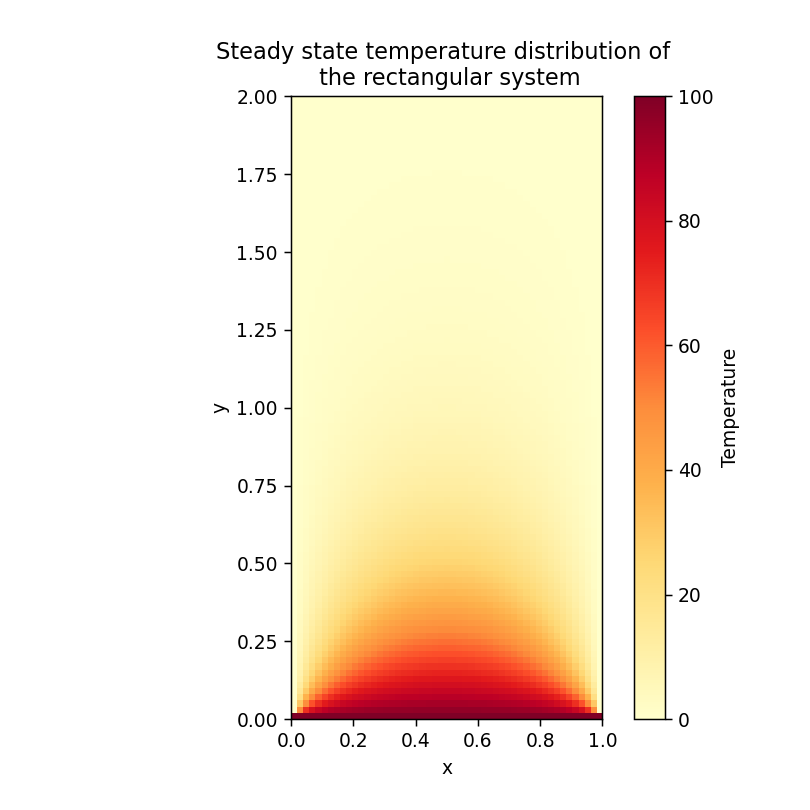

In [574]:
# Heat plot of the system
plt.figure(figsize=(6,6))
plt.imshow(Sys_Sol, origin='upper', extent=[0,1,0,2], cmap='YlOrRd')
plt.colorbar(label='Temperature')
plt.title("Steady state temperature distribution of \n the rectangular system")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

# 3. Further investigations

### Successive Over-relaxation Method
Explore the choice of $\omega$:
- Analytically solve for $\omega_{opt}$ assuming Young's theorem holds (state assumptions)
- plot iterations until convergence vs $\omega$ value to confirm it is optimal

#### Analytical $\omega_{opt}$ solution
Young's Theorem Requires:
- associated Jacobi scheme to only have real eigenvalues
- associated Jacobi scheme to converge ($\rho_J < 1$)
- $\det (\lambda D + zL + \frac{1}{z}U) = \det (\lambda D + L + U)$

Results in:
1. Rate of convergence: 
    1. $\rho = \frac{1}{4}\left(\omega \rho_J + \sqrt{\omega^2\rho_J^2 - 4(\omega - 1)}\right)^2$ for $0 < \omega < \omega_{opt}$
    2. $\rho = \omega - 1$ for $\omega_{opt} < \omega < 2$
2. Optimal $\omega$: 
    1. $\omega_{opt} = \frac{2-2\sqrt{1-\rho_J^2}}{\rho_J^2}$, where $\rho_J = \frac{\cos (\frac{\pi}{im}) + \beta^2 \cos (\frac{\pi}{jm})}{1 + \beta^2}$ with $\beta = \frac{\Delta x}{\Delta y}$

In [195]:
# step sizes
dx = L/im
dy = H/jm

# B coefficient in Jacobi scheme
B = dx/dy

# corresponding jacobi matrix spectral radius
p_J = (np.cos(np.pi / im) + B**2 * np.cos(np.pi / jm)) / (1 + B**2)
print(p_J)

# w_opt for consistently ordered matrix
SOR_w_opt = (2 - 2*np.sqrt(1 - p_J**2)) / p_J**2
SOR_w_opt

0.9987666443970016


1.9053958024423505

In [196]:
SOR_opt_Sol = SOR(w=SOR_w_opt, init_T=initial_T.copy())[0]
SOR_opt_Sol

327

#### Plots of iterations vs $\omega$

In [589]:
omegas = np.linspace(0, 2, 41)
omegas[-1] = 1.98
omegas[0] = 0.01

In [577]:
# Calculating number of iterations
SOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    SOR_w_Sol = SOR(w=w, init_T=initial_T.copy())[0]
    SOR_w_iterations.append(SOR_w_Sol)
    print(count) # to give an idea of progress

Slow convergence
1
Slow convergence
2
Slow convergence
3
Slow convergence
4
Slow convergence
5
Slow convergence
6
Slow convergence
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [578]:
SOR_w_iterations

[50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 48091,
 41067,
 35567,
 31144,
 27504,
 24455,
 21862,
 19631,
 17687,
 15979,
 14466,
 13114,
 11904,
 10805,
 9808,
 8901,
 8068,
 7300,
 6592,
 5935,
 5323,
 4753,
 4220,
 3719,
 3248,
 2803,
 2380,
 1977,
 1592,
 1219,
 848,
 420,
 623,
 1642]

<IPython.core.display.Javascript object>


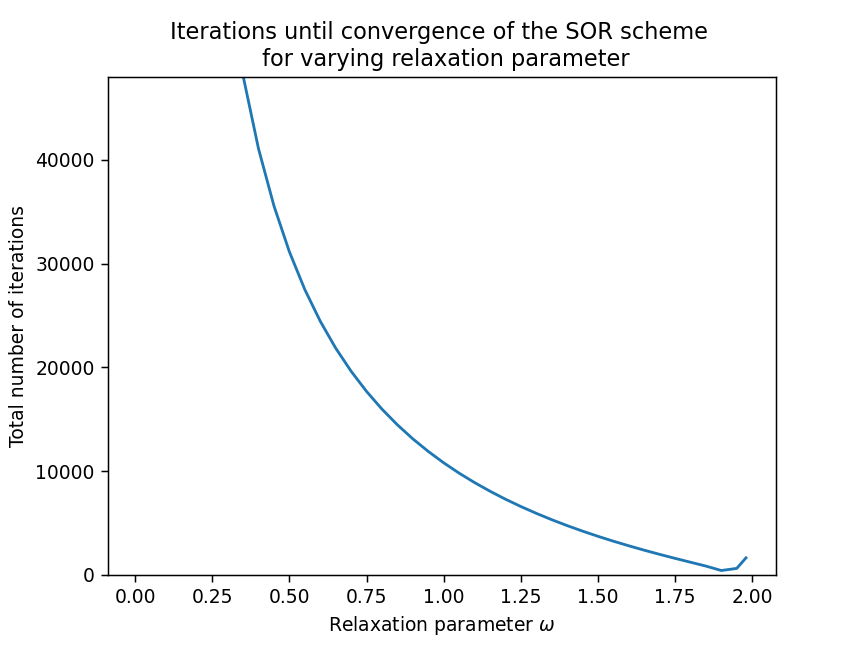

In [590]:
# Plot
plt.figure()
plt.plot(omegas, SOR_w_iterations)
plt.title('Iterations until convergence of the SOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.ylim(0, 48000)
plt.show()

In [591]:
# Refined search
omegas = np.linspace(1.8, 1.98, 50)

In [592]:
SOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    SOR_w_Sol = SOR(w=w, init_T=initial_T.copy())[0]
    SOR_w_iterations.append(SOR_w_Sol)
    print(count) # to give an idea of progress

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [593]:
SOR_w_iterations

[1219,
 1191,
 1165,
 1137,
 1110,
 1084,
 1056,
 1029,
 1002,
 974,
 948,
 920,
 893,
 866,
 837,
 809,
 782,
 753,
 724,
 694,
 666,
 636,
 606,
 574,
 542,
 507,
 471,
 430,
 381,
 321,
 335,
 353,
 370,
 393,
 407,
 429,
 455,
 475,
 510,
 544,
 591,
 632,
 680,
 748,
 823,
 913,
 1032,
 1179,
 1371,
 1642]

<IPython.core.display.Javascript object>


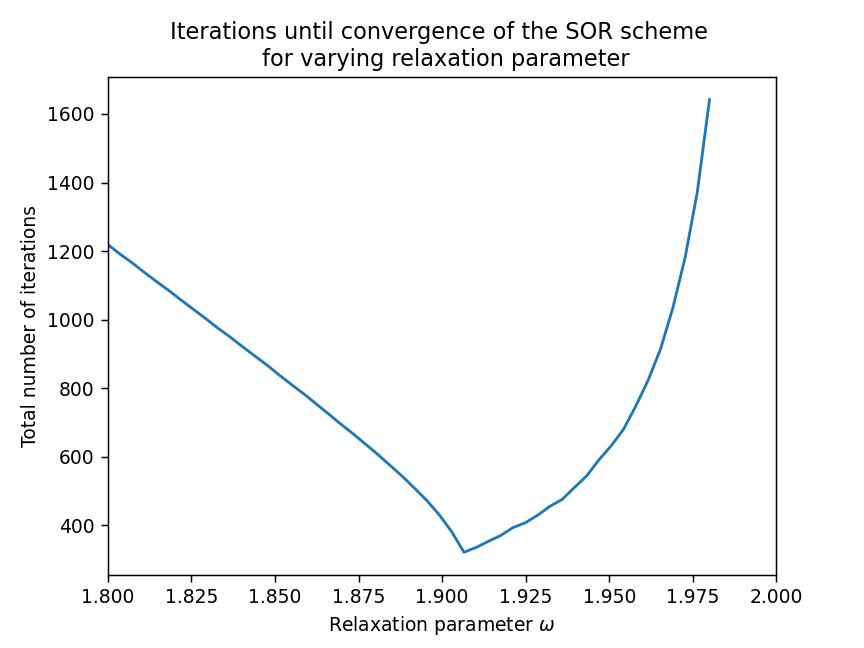

In [594]:
# Refined plot
plt.figure()
plt.plot(omegas, SOR_w_iterations)
plt.title('Iterations until convergence of the SOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.xlim(1.8, 2)
plt.show()

In [178]:
# implementing a grid search to get the optimal w value
omegas = np.linspace(1.9, 1.915, 101)
SOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    SOR_w_Sol = SOR(w=w, init_T=initial_T.copy())[0]
    SOR_w_iterations.append(SOR_w_Sol)
    print(count) # to give an idea of progress

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [179]:
SOR_w_iterations

[420,
 419,
 417,
 415,
 413,
 411,
 409,
 407,
 406,
 402,
 401,
 399,
 397,
 395,
 393,
 390,
 389,
 386,
 384,
 381,
 379,
 376,
 374,
 372,
 369,
 367,
 364,
 361,
 358,
 355,
 351,
 348,
 345,
 341,
 337,
 333,
 327,
 322,
 318,
 317,
 319,
 320,
 320,
 321,
 320,
 321,
 321,
 322,
 323,
 323,
 324,
 325,
 325,
 326,
 326,
 327,
 327,
 328,
 329,
 329,
 330,
 330,
 331,
 332,
 332,
 333,
 333,
 334,
 335,
 336,
 336,
 337,
 337,
 338,
 339,
 340,
 340,
 341,
 342,
 343,
 343,
 344,
 345,
 345,
 346,
 346,
 347,
 349,
 351,
 352,
 352,
 353,
 353,
 354,
 354,
 354,
 355,
 356,
 356,
 358,
 358]

In [199]:
loc_itmin = np.where(SOR_w_iterations == np.min(SOR_w_iterations))[0][0]
SOR_w_nopt = omegas[loc_itmin]
SOR_nopt_Sol = SOR_w_iterations[loc_itmin]

print('Numerical optimal w and number of iterations:')
print(SOR_w_nopt, SOR_nopt_Sol)
print('Analytical optimal w and number of iterations:')
print(SOR_w_opt, SOR_opt_Sol)

# very close to analytical value of 1.9053958024423505, but the numerical value performs better than the analytical one,
# so it is not a perfect result but is a good guideline and provides fast enough convergence.

Numerical optimal w and number of iterations:
1.90585 317
Analytical optimal w and number of iterations:
1.9053958024423505 327


### Line Successive Over-relaxation Method
Explore the choice of $\omega$:
- Plot iterations until convergence vs $\omega$ value to confirm it is optimal
- numerically solve for optimal $\omega$ (evaluate whether this technique is useful)
    - plot to observe general shape, then refine in region of interest

In [622]:
omegas = np.linspace(0, 2, 41)
omegas[-1] = 1.99
omegas[0] = 0.01

In [623]:
# Use the same approach as above, now implementing LSOR instead
LSOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    LSOR_w_Sol = LSOR_row(w=w, init_T=initial_T.copy())[0]
    LSOR_w_iterations.append(LSOR_w_Sol)
    print(count)

#NOTE: This code can run, I just cancelled it before submission.

Slow convergence
1
Slow convergence
2


KeyboardInterrupt: 

In [ ]:
LSOR_w_iterations = np.array(LSOR_w_iterations)
entireLSOR_w_iterations = LSOR_w_iterations

In [ ]:
first_nan_index = np.where(np.isnan(LSOR_w_iterations))[0][0]
first_nan = omegas[first_nan_index]
first_nan

In [ ]:
# Plot to observe general shape
plt.figure()
plt.plot(omegas, entireLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.ylim(0, 43000)
plt.show()

In [617]:
omegas = np.linspace(1.2, 1.35, 50)

In [606]:
# Refined search
LSOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    LSOR_w_Sol = LSOR_row(w=w, init_T=initial_T.copy())[0]
    LSOR_w_iterations.append(LSOR_w_Sol)
    print(count) # to give an idea of progress

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
with omega =1.3346938775510204, it fails to converge
45
with omega =1.3377551020408165, it fails to converge
46
with omega =1.3408163265306123, it fails to converge
47
with omega =1.3438775510204082, it fails to converge
48
with omega =1.3469387755102042, it fails to converge
49
with omega =1.35, it fails to converge
50


In [608]:
refLSOR_w_iterations = LSOR_w_iterations

<IPython.core.display.Javascript object>


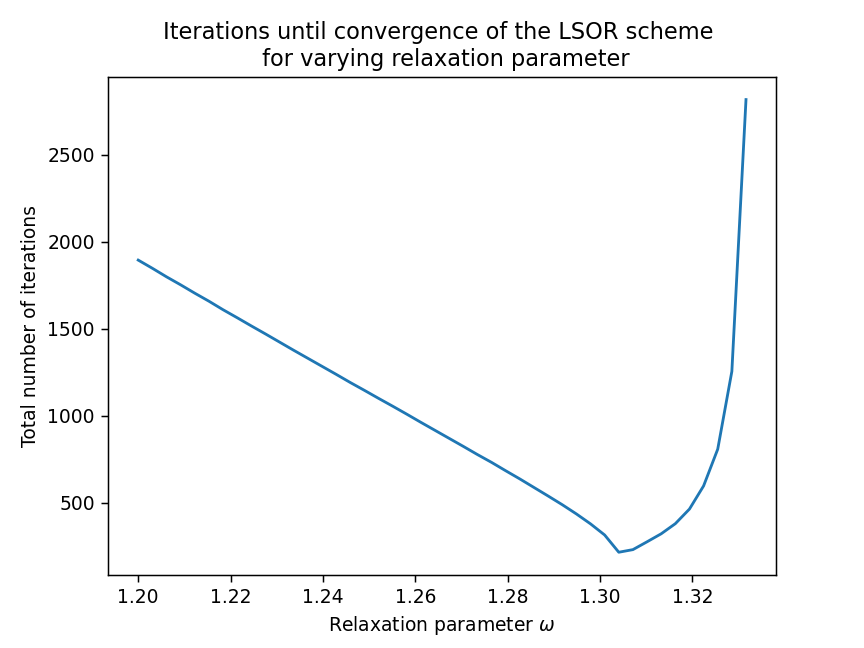

In [618]:
# Refined plot
plt.figure()
plt.plot(omegas, refLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.show()

In [408]:
loc_itmin = np.where(LSOR_w_iterations == np.min(LSOR_w_iterations[~np.isnan(LSOR_w_iterations)]))[0][0]
LSOR_w_nopt = omegas[loc_itmin]
LSOR_nopt_Sol = LSOR_w_iterations[loc_itmin]

print('Numerical optimal w and number of iterations:')
print(LSOR_w_nopt, LSOR_nopt_Sol)


# comment on different convergence behaviour. 1.304/217 

Numerical optimal w and number of iterations:
1.3040816326530613 217.0


### Line Gauss-Seidel and Line Successive Over-relaxation Methods
Explore effect of line parameterisation (line = row (j) or col (i)) on convergence:
- use $im = 100, jm = 100$
- compare number of iterations until convergence for the four alternatives

In [551]:
Line_initial_T = np.zeros((101, 101)) # im = jm = 100
Line_initial_T[-1,:] = 100
print(Line_initial_T)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [100. 100. 100. ... 100. 100. 100.]]


In [552]:
LGS_row_Sol = LGS_row(init_T=Line_initial_T.copy(), im=100, jm=100)
LGS_col_Sol = LGS_col(init_T=Line_initial_T.copy(), im=100, jm=100)

In [553]:
LGS_row_Sol[0]

5678

In [554]:
LGS_col_Sol[0]

21657

#### Getting numerically optimal $\omega$

##### 1. Row

In [521]:
omegas = np.linspace(0, 2, 41)
omegas[-1] = 1.99
omegas[0] = 0.01

In [522]:
# Use the same approach as above, now implementing LSOR instead
rowLSOR_w_iterations = []

count = 0
for n in omegas: # all but last one close to 2
    count += 1
    rowLSOR_w_Sol = LSOR_row(w=n, init_T=Line_initial_T.copy(), im = 100, jm = 100)[0]
    rowLSOR_w_iterations.append(rowLSOR_w_Sol)
    print(count)

Slow convergence
1
Slow convergence
2
Slow convergence
3
Slow convergence
4
Slow convergence
5
Slow convergence
6
Slow convergence
7
Slow convergence
8
Slow convergence
9
Slow convergence
10
Slow convergence
11
12
13
14
15
16
17
18
19
20
21
22
23
with omega =1.1500000000000001, it fails to converge
24
with omega =1.2000000000000002, it fails to converge
25
with omega =1.25, it fails to converge
26
with omega =1.3, it fails to converge
27
with omega =1.35, it fails to converge
28
with omega =1.4000000000000001, it fails to converge
29
with omega =1.4500000000000002, it fails to converge
30
with omega =1.5, it fails to converge
31
with omega =1.55, it fails to converge
32
with omega =1.6, it fails to converge
33
with omega =1.6500000000000001, it fails to converge
34
with omega =1.7000000000000002, it fails to converge
35
with omega =1.75, it fails to converge
36
with omega =1.8, it fails to converge
37
with omega =1.85, it fails to converge
38
with omega =1.9000000000000001, it fails to

In [523]:
rowLSOR_w_iterations

[50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 48168,
 40495,
 33960,
 28314,
 23384,
 19034,
 15165,
 11691,
 8547,
 5678,
 3029,
 460,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

<IPython.core.display.Javascript object>


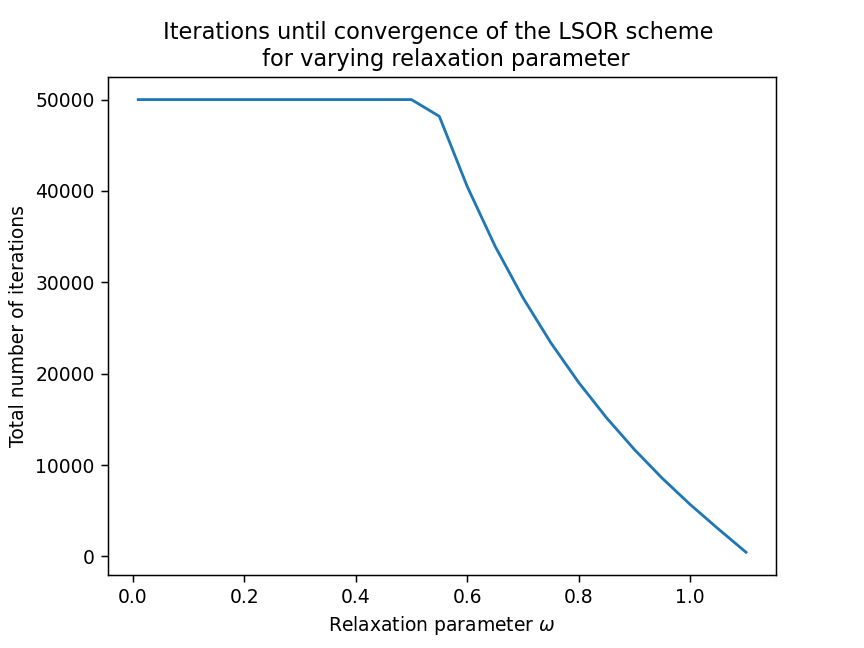

In [439]:
# Plot to observe general shape
plt.figure()
plt.plot(omegas, rowLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.ylim(0, 48000)
plt.show()

In [531]:
# see where search starts being undefined
first_nan_index = np.where(np.isnan(rowLSOR_w_iterations))[0][0]
first_nan = omegas[first_nan_index]
first_nan

1.1500000000000001

##### REFINED SEARCH

In [533]:
# Refined search
omegas = np.linspace(1.1, 1.15, 50)

ref_rowLSOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    rowLSOR_w_Sol = LSOR_row(w=w, init_T=Line_initial_T.copy(), im=100, jm=100)[0]
    ref_rowLSOR_w_iterations.append(rowLSOR_w_Sol)
    print(count) # to give an idea of progress

1
2
3
4
5
6
7
8
9
10
11
12
with omega =1.1122448979591837, it fails to converge
13
with omega =1.1132653061224491, it fails to converge
14
with omega =1.1142857142857143, it fails to converge
15
with omega =1.1153061224489795, it fails to converge
16
with omega =1.116326530612245, it fails to converge
17
with omega =1.1173469387755102, it fails to converge
18
with omega =1.1183673469387756, it fails to converge
19
with omega =1.1193877551020408, it fails to converge
20
with omega =1.1204081632653062, it fails to converge
21
with omega =1.1214285714285714, it fails to converge
22
with omega =1.1224489795918366, it fails to converge
23
with omega =1.123469387755102, it fails to converge
24
with omega =1.1244897959183673, it fails to converge
25
with omega =1.1255102040816327, it fails to converge
26
with omega =1.126530612244898, it fails to converge
27
with omega =1.1275510204081634, it fails to converge
28
with omega =1.1285714285714286, it fails to converge
29
with omega =1.1295918367

In [534]:
ref_rowLSOR_w_iterations

[460,
 395,
 319,
 225,
 254,
 313,
 368,
 467,
 625,
 927,
 1770,
 16029,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [544]:
# find index of first nan
first_nan_index = np.where(np.isnan(ref_rowLSOR_w_iterations))[0][0]
first_nan = omegas[first_nan_index]
first_nan
prev_val = omegas[first_nan_index - 1]

<IPython.core.display.Javascript object>


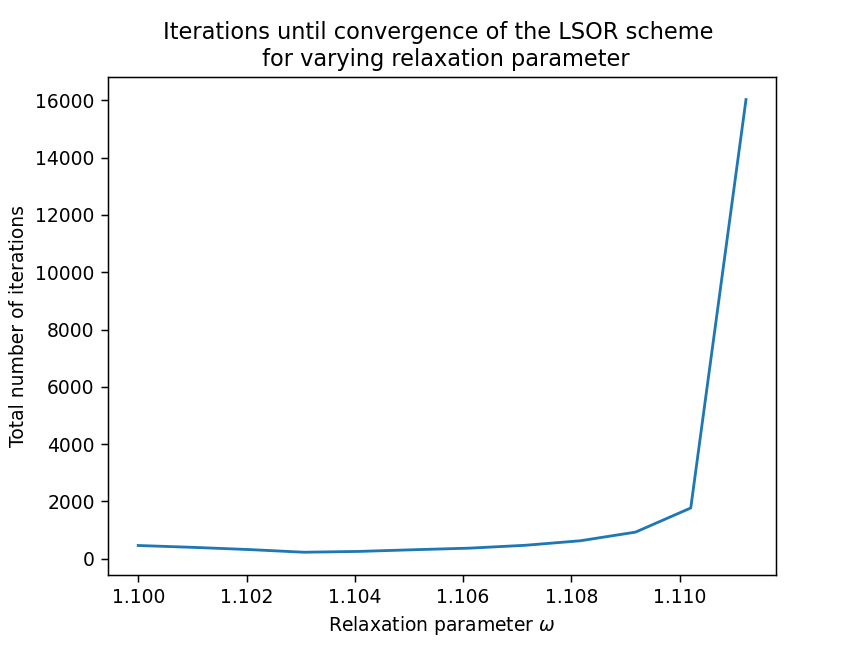

In [546]:
# Refined plot
plt.figure()
plt.plot(omegas, ref_rowLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.show()

In [547]:
# Get the optimal value
ref_rowLSOR_w_iterations = np.array(ref_rowLSOR_w_iterations)

loc_itmin = np.where(ref_rowLSOR_w_iterations == np.min(ref_rowLSOR_w_iterations[~np.isnan(ref_rowLSOR_w_iterations)]))[0][0]
rowLSOR_w_nopt = omegas[loc_itmin]
rowLSOR_nopt_Sol = ref_rowLSOR_w_iterations[loc_itmin]

print('Row Numerical optimal w and number of iterations:')
print(rowLSOR_w_nopt, rowLSOR_nopt_Sol)


# comment on different convergence behaviour.

Row Numerical optimal w and number of iterations:
1.103061224489796 225.0


##### 2. Column

In [566]:
omegas = np.linspace(0, 2, 41)
omegas[-1] = 1.99
omegas[0] = 0.01

In [558]:
# Use the same approach as above, now implementing LSOR instead
colLSOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    colLSOR_w_Sol = LSOR_col(w=w, init_T=Line_initial_T.copy(), im = 100, jm = 100)[0]
    colLSOR_w_iterations.append(colLSOR_w_Sol)
    print(count)

Slow convergence
1
Slow convergence
2
Slow convergence
3
Slow convergence
4
Slow convergence
5
Slow convergence
6
Slow convergence
7
Slow convergence
8
Slow convergence
9
Slow convergence
10
Slow convergence
11
Slow convergence
12
Slow convergence
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
with omega =1.7000000000000002, it fails to converge
35
with omega =1.75, it fails to converge
36
with omega =1.8, it fails to converge
37
with omega =1.85, it fails to converge
38
with omega =1.9000000000000001, it fails to converge
39
with omega =1.9500000000000002, it fails to converge
40
with omega =1.99, it fails to converge
41


<IPython.core.display.Javascript object>


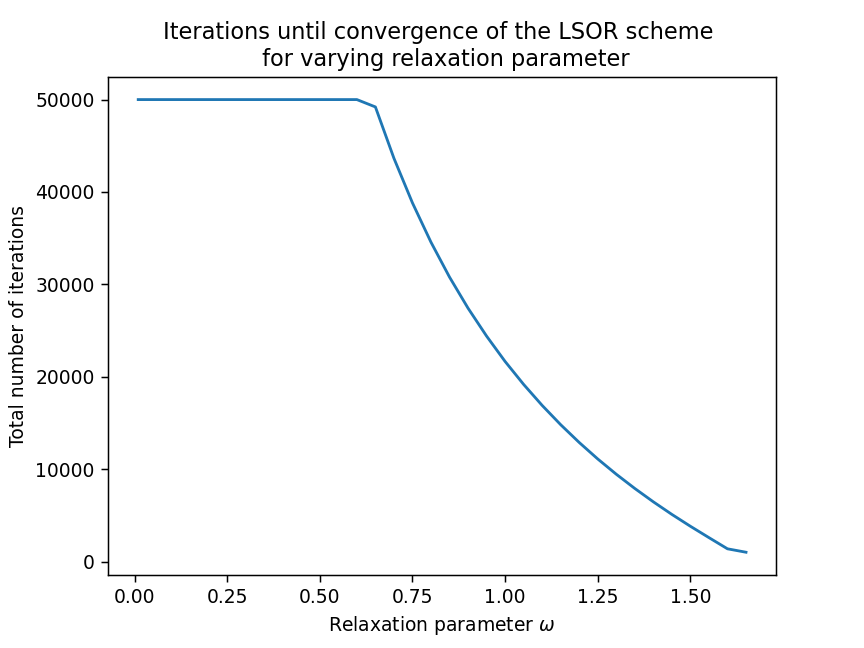

In [559]:
# Plot to observe general shape
plt.figure()
plt.plot(omegas, colLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.show()

In [560]:
colLSOR_w_iterations

[50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 50000,
 49204,
 43648,
 38818,
 34563,
 30789,
 27424,
 24404,
 21657,
 19174,
 16901,
 14814,
 12890,
 11106,
 9454,
 7913,
 6468,
 5107,
 3823,
 2595,
 1385,
 1014,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [570]:
# find index of first nan
first_nan_index = np.where(np.isnan(colLSOR_w_iterations))[0][0]
first_nan = omegas[first_nan_index]
first_nan

1.7000000000000002


In [ ]:
# see where search starts being undefined


In [569]:
# Refined search
omegas = np.linspace(1.6, 1.65, 50)

ref_colLSOR_w_iterations = []

count = 0
for w in omegas: # all but last one close to 2
    count += 1
    colLSOR_w_Sol = LSOR_col(w=w, init_T=Line_initial_T.copy(), im = 100, jm=100)[0]
    ref_colLSOR_w_iterations.append(colLSOR_w_Sol)
    print(count) # to give an idea of progress
    print(w)
    print(colLSOR_w_Sol) #iteration number

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Slow convergence
18
with omega =1.6683673469387754, it fails to converge
19
with omega =1.6693877551020408, it fails to converge
20
with omega =1.670408163265306, it fails to converge
21
with omega =1.6714285714285713, it fails to converge
22
with omega =1.6724489795918367, it fails to converge
23
with omega =1.673469387755102, it fails to converge
24
with omega =1.6744897959183673, it fails to converge
25
with omega =1.6755102040816325, it fails to converge
26
with omega =1.676530612244898, it fails to converge
27
with omega =1.6775510204081632, it fails to converge
28
with omega =1.6785714285714286, it fails to converge
29
with omega =1.6795918367346938, it fails to converge
30
with omega =1.680612244897959, it fails to converge
31
with omega =1.6816326530612244, it fails to converge
32
with omega =1.6826530612244897, it fails to converge
33
with omega =1.683673469387755, it fails to converge
34
with omega =1.6846938775510203, it fails to con

In [573]:
ref_colLSOR_w_iterations

array([ 1015.,  1075.,  1147.,  1236.,  1327.,  1452.,  1582.,  1755.,
        1943.,  2223.,  2540.,  3017.,  3693.,  4787.,  6680., 11272.,
       35650., 50000.,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan])

In [575]:
omegas

array([1.65      , 1.65102041, 1.65204082, 1.65306122, 1.65408163,
       1.65510204, 1.65612245, 1.65714286, 1.65816327, 1.65918367,
       1.66020408, 1.66122449, 1.6622449 , 1.66326531, 1.66428571,
       1.66530612, 1.66632653, 1.66734694, 1.66836735, 1.66938776,
       1.67040816, 1.67142857, 1.67244898, 1.67346939, 1.6744898 ,
       1.6755102 , 1.67653061, 1.67755102, 1.67857143, 1.67959184,
       1.68061224, 1.68163265, 1.68265306, 1.68367347, 1.68469388,
       1.68571429, 1.68673469, 1.6877551 , 1.68877551, 1.68979592,
       1.69081633, 1.69183673, 1.69285714, 1.69387755, 1.69489796,
       1.69591837, 1.69693878, 1.69795918, 1.69897959, 1.7       ])

<IPython.core.display.Javascript object>


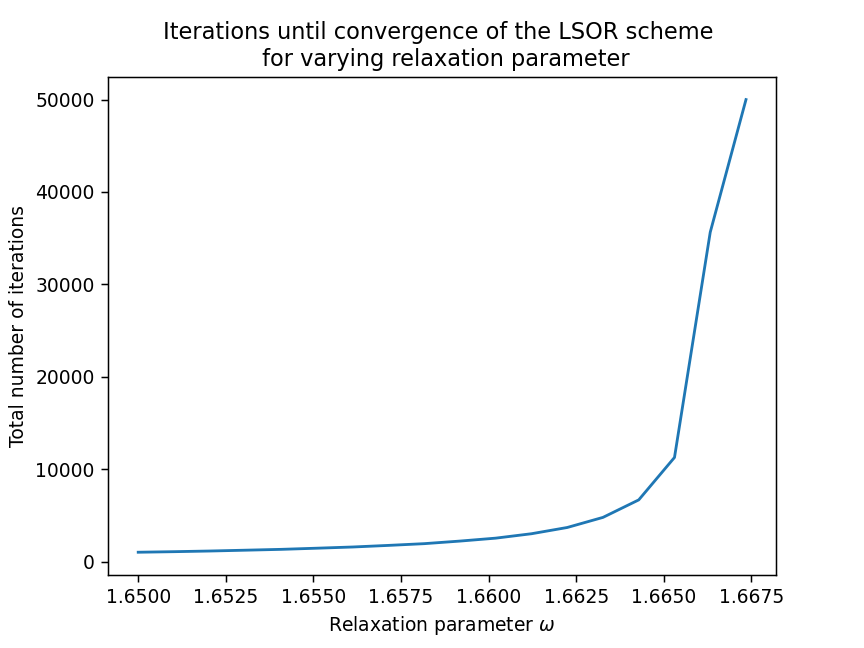

In [571]:
# Refined plot
plt.figure()
plt.plot(omegas, ref_colLSOR_w_iterations)
plt.title('Iterations until convergence of the LSOR scheme \n for varying relaxation parameter')
plt.ylabel('Total number of iterations')
plt.xlabel('Relaxation parameter $\\omega$')
plt.show()

In [572]:
# Get the optimal value
ref_colLSOR_w_iterations = np.array(ref_colLSOR_w_iterations)

loc_itmin = np.where(ref_colLSOR_w_iterations == np.min(ref_colLSOR_w_iterations[~np.isnan(ref_colLSOR_w_iterations)]))[0][0]
colLSOR_w_nopt = omegas[loc_itmin]
colLSOR_nopt_Sol = ref_colLSOR_w_iterations[loc_itmin]

print('Column Numerical optimal w and number of iterations:')
print(colLSOR_w_nopt, colLSOR_nopt_Sol)


# comment on different convergence behaviour.

Column Numerical optimal w and number of iterations:
1.65 1015.0


#### LSOR Results for row and column orientations

In [619]:
LSOR_row_Sol = LSOR_row(w = rowLSOR_w_nopt, init_T=Line_initial_T.copy(), im=100, jm=100)
LSOR_col_Sol = LSOR_col(w = colLSOR_w_nopt, init_T=Line_initial_T.copy(), im=100, jm=100)

In [620]:
LSOR_row_Sol[0]

225

In [621]:
LSOR_col_Sol[0]

1015

### Line Gauss-Seidel Method
Explore changing the initial $T_0$ effect on convergence:
- use values $T_0 = 0, 20, 50, 80, 100$
- use row LGS for this (line = row) 

In [441]:
# T0 = 0
T0_0 = LGS_row(init_T=initial_T.copy())[0] # calculated prior
T0_0

5537

In [442]:
# T0 = 20
initial_T_20 = initial_T.copy()

for j in range(1, jm):
    for i in range(1, im):
        initial_T_20[j,i] = 20

T0_20 = LGS_row(init_T=initial_T_20.copy())[0]
T0_20

5587

In [443]:
# T0 = 50
initial_T_50 = initial_T.copy()

for j in range(1, jm):
    for i in range(1, im):
        initial_T_50[j,i] = 50

        
T0_50 = LGS_row(init_T=initial_T_50.copy())[0]
T0_50

5851

In [444]:
# T0 = 80
initial_T_80 = initial_T.copy()

for j in range(1, jm):
    for i in range(1, im):
        initial_T_80[j,i] = 80

T0_80 = LGS_row(init_T=initial_T_80.copy())[0]
T0_80

5962

In [445]:
# T0 = 100
initial_T_100 = initial_T.copy()

for j in range(1, jm):
    for i in range(1, im):
        initial_T_100[j,i] = 100

T0_100 = LGS_row(init_T=initial_T_100.copy())[0]
T0_100

6013

#### Plot of iterations vs $T_0$

<IPython.core.display.Javascript object>


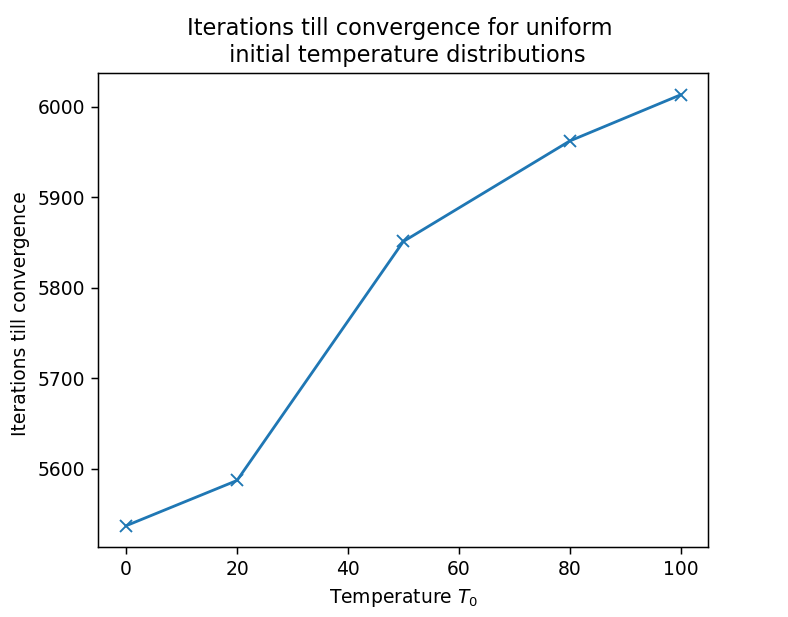

In [458]:
T0s = [0, 20, 50, 80, 100]
T0_iterations = [T0_0, T0_20, T0_50, T0_80, T0_100]

plt.figure()
plt.plot(T0s, T0_iterations, marker='x')

plt.title('Iterations till convergence for uniform \n initial temperature distributions')
plt.ylabel('Iterations till convergence ')
plt.xlabel('Temperature $T_0$')
plt.show()

### Across all methods
Investigate the convergence of the methods:
- Plot residual value vs iteration number

#### 1. Jacobi

In [374]:
# Calculate solution
J_Sol = Jacobi(init_T=initial_T.copy())

In [375]:
J_Sol

(21096,
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88002970e-03, 3.75263913e-03, ...,
         3.75263913e-03, 1.88002970e-03, 0.00000000e+00],
        [0.00000000e+00, 3.76747966e-03, 7.52008948e-03, ...,
         7.52008948e-03, 3.76747966e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.01510220e+01, 4.98323582e+01, ...,
         4.98323582e+01, 3.01510220e+01, 0.00000000e+00],
        [0.00000000e+00, 4.99580893e+01, 6.96813353e+01, ...,
         6.96813353e+01, 4.99580893e+01, 0.00000000e+00],
        [1.00000000e+02, 1.00000000e+02, 1.00000000e+02, ...,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02]]),
 [1225.0,
  906.25,
  750.0,
  651.953125,
  583.59375,
  532.2265625,
  491.943359375,
  459.17510986328125,
  431.9000244140625,
  408.697509765625,
  388.6751174926758,
  371.14500999450684,
  355.64690828323364,
  341.8028265237808,
  329.3489947915077,

In [376]:
# Plot residuals over time
J_residuals = J_Sol[2]
J_iterations = [i + 1 for i in range(len(J_residuals))]

#### 2. Gauss-Seidel

In [377]:
# Calculate solution
GS_Sol = Gauss_Seidel(init_T=initial_T.copy())

In [378]:
GS_Sol

(10806,
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88002970e-03, 3.75263913e-03, ...,
         3.75263913e-03, 1.88002970e-03, 0.00000000e+00],
        [0.00000000e+00, 3.76747966e-03, 7.52008948e-03, ...,
         7.52008948e-03, 3.76747966e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.01510220e+01, 4.98323582e+01, ...,
         4.98323582e+01, 3.01510220e+01, 0.00000000e+00],
        [0.00000000e+00, 4.99580893e+01, 6.96813353e+01, ...,
         6.96813353e+01, 4.99580893e+01, 0.00000000e+00],
        [1.00000000e+02, 1.00000000e+02, 1.00000000e+02, ...,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02]]),
 [2425.0,
  1588.8888888888891,
  1220.3703703703704,
  1016.2465706447186,
  884.8376652758724,
  791.7316604410374,
  721.4543943095007,
  666.0175176676555,
  620.8532031412493,
  583.1422610951377,
  551.0400315974367,
  523.2827815578603,
  498.9721384

In [379]:
# Plot residuals over time
GS_residuals = GS_Sol[2]
GS_iterations = [i + 1 for i in range(len(GS_residuals))]

#### 3. LGS (constant j)

In [380]:
# Calculate solution
LGS_Sol = LGS_row(init_T=initial_T.copy())

In [381]:
LGS_Sol

(5537,
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88002970e-03, 3.75263913e-03, ...,
         3.75263913e-03, 1.88002970e-03, 0.00000000e+00],
        [0.00000000e+00, 3.76747966e-03, 7.52008949e-03, ...,
         7.52008949e-03, 3.76747966e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.01510220e+01, 4.98323582e+01, ...,
         4.98323582e+01, 3.01510220e+01, 0.00000000e+00],
        [0.00000000e+00, 4.99580893e+01, 6.96813353e+01, ...,
         6.96813353e+01, 4.99580893e+01, 0.00000000e+00],
        [1.00000000e+02, 1.00000000e+02, 1.00000000e+02, ...,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02]]),
 [4776.393202250021,
  2323.954740521565,
  1710.8292190375041,
  1404.334621771035,
  1212.8061127596584,
  1078.7506717153015,
  978.2167943355319,
  899.2303806156061,
  835.0567323361151,
  781.5805556674321,
  736.1270959600567,
  696.872761415117,
  66

In [382]:
LGS_residuals = LGS_Sol[2]
LGS_iterations = [i + 1 for i in range(len(LGS_residuals))]

#### 4. SOR

In [383]:
# Calculate solution
SOR_Sol = SOR(w = SOR_w_opt, init_T=initial_T.copy())

In [384]:
SOR_Sol

(327,
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88002970e-03, 3.75263913e-03, ...,
         3.75263913e-03, 1.88002970e-03, 0.00000000e+00],
        [0.00000000e+00, 3.76747966e-03, 7.52008949e-03, ...,
         7.52008949e-03, 3.76747966e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.01510220e+01, 4.98323582e+01, ...,
         4.98323582e+01, 3.01510220e+01, 0.00000000e+00],
        [0.00000000e+00, 4.99580893e+01, 6.96813353e+01, ...,
         6.96813353e+01, 4.99580893e+01, 0.00000000e+00],
        [1.00000000e+02, 1.00000000e+02, 1.00000000e+02, ...,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02]]),
 [39301.56800597923,
  4642.463616965234,
  3813.4325683451184,
  3361.7389387984904,
  3018.582848786709,
  2726.8099894777265,
  2476.758665930251,
  2256.208736800102,
  2058.9780566132495,
  1883.9097282135424,
  1725.8233257308348,
  1582.729133939863,
 

In [385]:
SOR_residuals = SOR_Sol[2]
SOR_iterations = [i + 1 for i in range(len(SOR_residuals))]

#### 5. LSOR

In [387]:
# Calculate solution
LSOR_Sol = LSOR_row(w = LSOR_w_nopt, init_T=initial_T.copy())

In [388]:
LSOR_Sol

(217,
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88002970e-03, 3.75263913e-03, ...,
         3.75263913e-03, 1.88002970e-03, 0.00000000e+00],
        [0.00000000e+00, 3.76747966e-03, 7.52008949e-03, ...,
         7.52008949e-03, 3.76747966e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.01510220e+01, 4.98323582e+01, ...,
         4.98323582e+01, 3.01510220e+01, 0.00000000e+00],
        [0.00000000e+00, 4.99580893e+01, 6.96813353e+01, ...,
         6.96813353e+01, 4.99580893e+01, 0.00000000e+00],
        [1.00000000e+02, 1.00000000e+02, 1.00000000e+02, ...,
         1.00000000e+02, 1.00000000e+02, 1.00000000e+02]]),
 [62686.41782325958,
  4090.9815874693913,
  2157.3371137790587,
  1267.5805815954527,
  818.8334806124503,
  576.4976042708561,
  437.9753454715821,
  353.92136469189427,
  299.32540588871484,
  259.92931052333284,
  227.89646679542437,
  199.53922414508503,

In [389]:
LSOR_residuals = LSOR_Sol[2]
LSOR_iterations = [i + 1 for i in range(len(LSOR_residuals))]

### COMPARISON PLOT

<IPython.core.display.Javascript object>


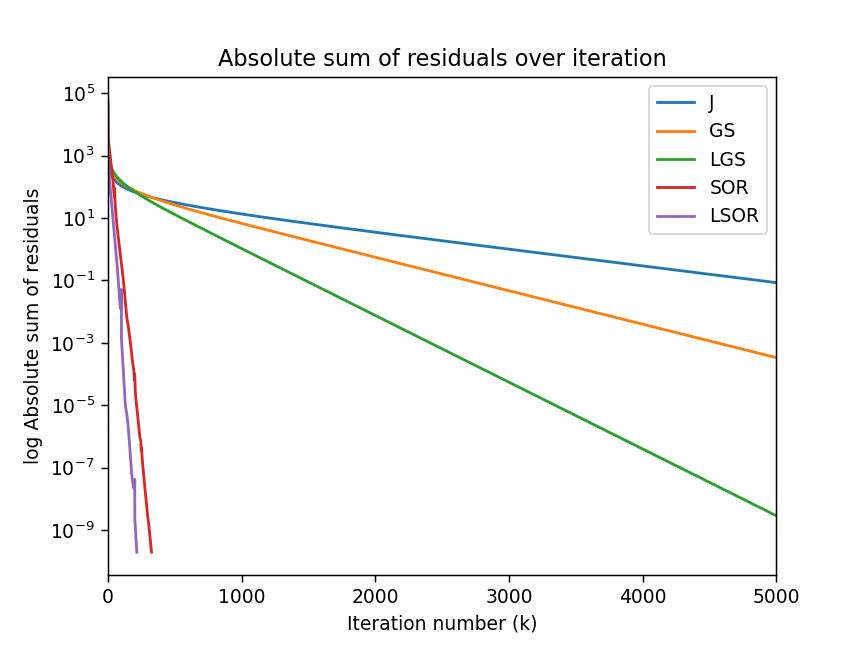

In [459]:
plt.figure()
plt.semilogy(J_iterations, J_residuals, label='J')
plt.semilogy(GS_iterations, GS_residuals, label='GS')
plt.semilogy(LGS_iterations, LGS_residuals, label='LGS')
plt.semilogy(SOR_iterations, SOR_residuals, label='SOR')
plt.semilogy(LSOR_iterations, LSOR_residuals, label='LSOR')
plt.title('Absolute sum of residuals over iteration')
plt.ylabel('log Absolute sum of residuals')
plt.xlabel('Iteration number (k)')
plt.xlim(0, 5000)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


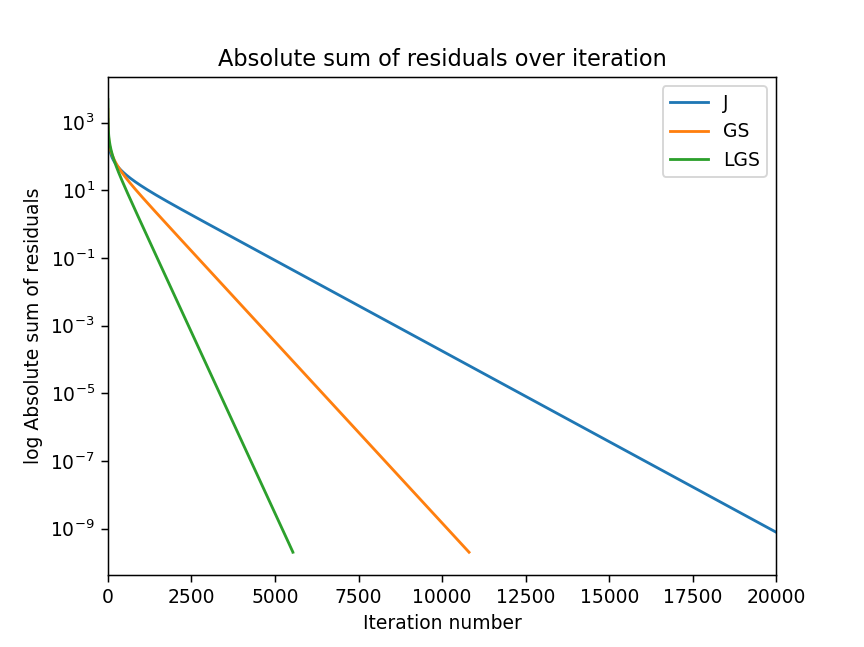

In [460]:
plt.figure()
plt.semilogy(J_iterations, J_residuals, label='J')
plt.semilogy(GS_iterations, GS_residuals, label='GS')
plt.semilogy(LGS_iterations, LGS_residuals, label='LGS')
plt.title('Absolute sum of residuals over iteration')
plt.ylabel('log Absolute sum of residuals')
plt.xlabel('Iteration number')
plt.xlim(0, 20000)
plt.legend()
plt.show()
plt.show()

<IPython.core.display.Javascript object>


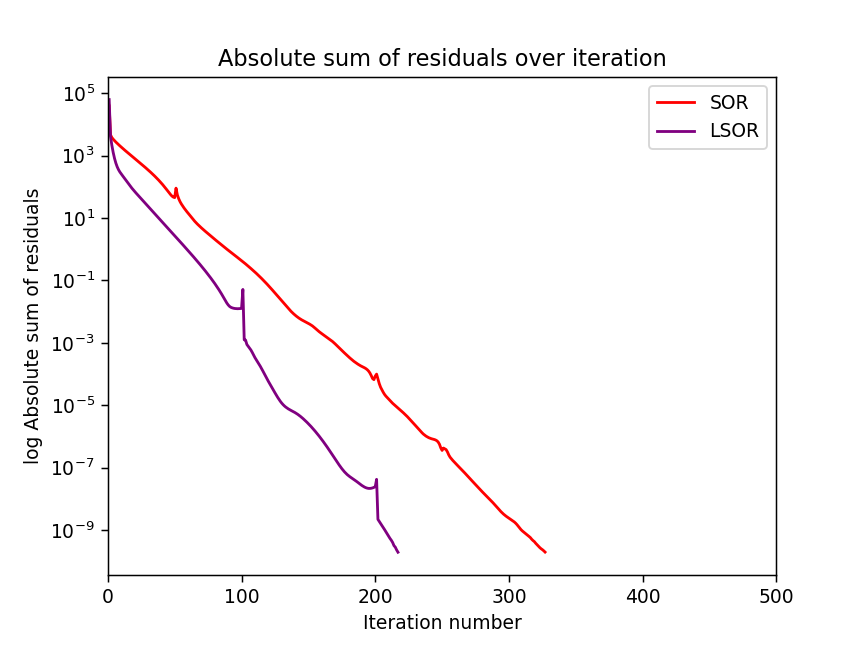

In [461]:
plt.figure()
plt.semilogy(SOR_iterations, SOR_residuals, label='SOR', color='red')
plt.semilogy(LSOR_iterations, LSOR_residuals, label='LSOR', color='purple')
plt.title('Absolute sum of residuals over iteration')
plt.ylabel('log Absolute sum of residuals')
plt.xlabel('Iteration number')
plt.xlim(0, 500)
plt.legend()
plt.show()
plt.show()